<a href="https://colab.research.google.com/github/sid8123/qml/blob/master/VQLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install qiskit
!pip install pytket-qiskit
!pip install qiskit[visualization]
!pip install pytket.backends.ibm

from IPython.display import clear_output
clear_output(wait=False)

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

#Operator Imports

from qiskit.aqua.operators import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.aqua.operators.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit.aqua.operators.operator_base import OperatorBase
#Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2
# import pennylane as qml
# from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
# from pennylane.templates.state_preparations import MottonenStatePreparation as msp
# from pennylane.templates.state_preparations import ArbitraryStatePreparation as asp
# from pennylane.templates import ParticleConservingU2
from functools import partial
import random
import numpy as np
from scipy.optimize import minimize
from sympy import *
init_printing(use_unicode=True)
import time as time
from qiskit import *


## pytket imports
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.extensions.qiskit import AerBackend as tket_AerBackend
from pytket.utils import Graph


In [10]:
def convert_bin(num , ancilla_size = 0):
    n = ancilla_size                       # for 6 digits
    b = bin(num)[2:]
    l = len(b)
    b = str(0) * (n - l) + b
    b = b[::-1]
    return(b)


In [11]:
def decompose(n,A):
  I = Matrix([[1,0],[0,1]])
  X = Matrix([[0,1],[1,0]])
  Z = Matrix([[1,0],[0,-1]])
  Y = Matrix([[0,-1],[1,0]])
  l = [I, X, Z,Y]
  ls = ['I','X','Z','Y']
  combinations = []
  comb = []
  for i in range(4):
    if n == 1 :
      combinations.append(l[i])
      comb.append(ls[i])
    elif n == 2  :
      for j in range(4):
        combinations.append(Matrix(np.kron(l[i],l[j])))
        comb.append(ls[i] + ls[j])
    elif n==3 : 
      for j in range(4):
        for k in range(4):
          combinations.append(Matrix(np.kron(np.kron(l[i],l[j]),l[k])))
          comb.append(ls[i]+ls[j]+ls[k])
    elif n == 4 :     
      for j in range(4):
        for k in range(4):
          for m in range(4):
            combinations.append(np.kron(np.kron(np.kron(l[i],l[j]),l[k]),l[m]))
            comb.append(ls[i]+ls[j]+ls[k]+ls[m])
    elif n == 5 : 
      for j in range(4):
        for k in range(4):
          for m in range(4):
            for N in range(4):
              combinations.append(np.kron(np.kron(np.kron(np.kron(l[i],l[j]),l[k]),l[m]),l[N]))
              comb.append(ls[i]+ls[j]+ls[k]+ls[m]+ls[N])
              
    elif n == 6 :
      for j in range(4):
        for k in range(4):
          for m in range(4):
            for N in range(4):
              for o in range(4):
                combinations.append(np.kron(np.kron(np.kron(np.kron(np.kron(l[i],l[j]),l[k]),l[m]),l[N]),l[o]))
                comb.append(ls[i]+ls[j]+ls[k]+ls[m]+ls[N]+ls[o])
  r = len(combinations)
  d = []
  for x in range(0, r ):
      strng = 'a'+str(x+1)
      d.append(symbols(strng))
  M = zeros(pow(2,n) , pow(2,n))
  for i in range(len(combinations)):
    M = M + d[i]*combinations[i]
  M = M - A
  eq = [M[i] for i in range(r)]
  sol = list(linsolve(eq,d))
  SOL = {}
  Comb = []
  for i in range(len(sol[0])) :
    if sol[0][i] != 0 :
        SOL[comb[i]] = sol[0][i]
        Comb.append(combinations[i])
  return(Comb , list(SOL.values()) , list(SOL.keys()))

In [12]:
def get_hyperparmeters(A_size,num_unitaries):
    global n_qubits , ancilla_size , n_shots , tot_qubits , ancilla_idx , steps , eta , q_delta , rng_seed
    n_qubits = int(A_size)                        # Number of system qubits
    ancilla_size = int(np.ceil(np.log2(num_unitaries)))                # Number of ancillary qubit
    n_shots = 10 ** 6                                  # Number of quantum measurements
    tot_qubits = int(n_qubits + ancilla_size)                          # System + ancillary qubits
    ancilla_idx = 0                                    # Index of the first ancillary qubit
    steps = 1000                                       # Number of optimization steps
    eta = 0.1                                         # Learning rate
    q_delta = 0.001                                    # Initial spread of random quantum weights
    rng_seed = 0                                       #  Seed for random number generator

In [13]:
I = [[1,0],[0,1]]
X = [[0,1],[1,0]]
Z = [[1,0],[0,-1]]

A = np.kron(np.kron(I,I),I) + 0.2*np.kron((np.kron(I,Z)),X) + 0.2*np.kron(np.kron(I,I),X)
Unitaries , coefficients , keys =  decompose(int(np.log2(np.sqrt(A.size))),A)
get_hyperparmeters(np.ceil(np.log2(np.sqrt(A.size))) , len(coefficients))

In [14]:
def UC():
    global c
    c = [0] + coefficients
    for i in range(len(c) , 2**ancilla_size):
        c.append(0)
    s_c = sum(c)
    c = [ np.sqrt(float(_ /s_c)) for _ in c]
    uc = QuantumCircuit(ancilla_size ,name = 'UC')
    uc.initialize(c , [_ for _ in range(ancilla_size)])
    uc = compiler.transpile(uc , basis_gates = ['u3','cx'],optimization_level = 3)
    return(uc)

def UCD():
    ucd = UC()
    ucd = ucd.inverse()
    return(ucd)

def UB():
    ub = QuantumCircuit(n_qubits ,name= 'B_dg')
    ub.h([_ for _ in range(n_qubits)])
    return(ub)

In [16]:
def make_Ai(key,control_list):
    Ai = QuantumCircuit(tot_qubits)
    key = key[::-1]
    for _ in range(len(key)):
        if key[_] == 'I':
            q = QuantumCircuit(1, name = 'I')
            MCX = qiskit.circuit.library.MCMT(q.decompose().to_gate(),len(control_list),1)
            apply_bits = control_list + [ancilla_size + _]
            Ai.append(MCX,apply_bits)
        if key[_] == 'X':
            MCX = qiskit.circuit.library.MCMT(Ai.x,len(control_list),1)
            apply_bits = control_list + [ancilla_size + _]
            Ai.append(MCX,apply_bits)
        if key[_] == 'Z':
            MCX = qiskit.circuit.library.MCMT(Ai.z,len(control_list),1)
            apply_bits = control_list + [ancilla_size + _]
            Ai.append(MCX,apply_bits)
        if key[_] == 'Y':
            MCX = qiskit.circuit.library.MCMT(Ai.y,len(control_list),1)
            apply_bits = control_list + [ancilla_size + _]
            Ai.append(MCX,apply_bits)
    return(Ai.decompose())

In [17]:
def CA():
    qc = QuantumCircuit(tot_qubits,name ='CA')
    for idx in range(1,len(keys)+1):
        control_bin = convert_bin(idx,ancilla_size)
        control_size = len([ _ for _ in control_bin if _ == '1' ])
        control_bits = []
        for j in range(len(control_bin)):
            if control_bin[j] == '1':
                control_bits.append(j)
        working_bits = [_  for _ in range(tot_qubits) ]
        qc.append(make_Ai(keys[idx-1],control_bits),working_bits)
        qc.barrier()
    return(qc.decompose())

In [19]:
def var_circuit(parameters):
    vc = QuantumCircuit(tot_qubits,name = 'var_circuit')
    for idx in range(1,len(keys)+1):
        control_bin = convert_bin(idx,ancilla_size)
        control_size = len([ _ for _ in control_bin if _ == '1' ])
        control_bits = []
        for j in range(len(control_bin)):
            if control_bin[j] == '1':
                control_bits.append(j)
        for n_idx in range(n_qubits):
            q = QuantumCircuit(1,name = 'cry')
            q.ry(parameters[idx-1][n_idx],0)
            working_bits = control_bits + [n_idx + ancilla_size]
            mcry = qiskit.circuit.library.MCMT(q.to_gate(),len(control_bits),1)
            vc.append(mcry,working_bits)
        vc.barrier()
    return(vc.decompose())

In [21]:
def full_circuit(parameters):
    FC =  QuantumCircuit(tot_qubits)
    tot_qubits_list = [_ for _ in range(tot_qubits)] 
    ancilla_list = [_ for _ in range(ancilla_size)]
    system_list =  [_ + ancilla_size for _ in range(n_qubits)]
    
    FC.append(UC(), ancilla_list)
    FC.barrier()
    
    FC.append(var_circuit(parameters) , tot_qubits_list)
    FC.barrier()
    
    FC.append(CA(),tot_qubits_list)
    FC.barrier()
    
    #FC.append(UB(),system_list)
    #FC.barrier()

    FC.append(UCD(),ancilla_list)

    ## UPDATE - tranpiled in u3 and cx gates only
    FC = compiler.transpile(FC , basis_gates = ['u3','cx'],optimization_level = 3)
    
    return(FC)

In [23]:
## UPDATE - output from tket compiled circuit is passed through
##          this function to match the dtype same as qiskit o/p

def convert_format_to_qiskit(job):
    keys = list(job.keys())

    key_list = []
    value_list = []

    for key in keys:
        value_list.append(job[key])
        res = ''
        for i in key:
            res += str(i)
        key_list.append(res)
    
    dic = dict(zip(key_list, value_list))
    return dic

In [24]:
def global_ground_qiskit(weights):
    
    num_parameters = len(keys) * n_qubits
    parameters = []
    for i in range(num_parameters):
        parameters.append(Parameter('w_' + str(i)))
        
    weights = weights
    value_dict = {}
    for i in range(len(parameters)) :
        value_dict[parameters[i]] = float(weights[i])
    
    parameters = np.array(parameters).reshape(len(keys),n_qubits)
    
    circuit = QuantumCircuit(tot_qubits,n_qubits)
    circuit.append(full_circuit(parameters),[_ for _ in range(tot_qubits)])
    circuit = circuit.bind_parameters(value_dict)
    circuit.measure([ ancilla_size + _ for _ in range(n_qubits)],[_ for _ in range(n_qubits)])
    
    job = execute(circuit,backend = Aer.get_backend('qasm_simulator'),shots = n_shots,optimization_level = 3).result().get_counts()
    stv = []
    for i in range(2**n_qubits):
        if convert_bin(i,n_qubits) in job.keys():
            stv.append(job[convert_bin(i,n_qubits)])
        else :
            stv.append(0)
    stv = np.array(stv)
    stv = stv/np.linalg.norm(stv)
    
    b = np.ones(2**n_qubits)
    b = b/np.linalg.norm(b)
    
    cost = np.matmul(np.matrix.getH(b),stv)
    
    return(cost)

def cost_fn_qiskit(weights):

    global Cost_hist
    
    p_gg = global_ground_qiskit(weights)
    Cost_hist.append(1 - p_gg)
    return(1 - p_gg)

In [26]:
def global_ground_qiskit_tket(weights):
    
    num_parameters = len(keys) * n_qubits
    parameters = []
    for i in range(num_parameters):
        parameters.append(Parameter('w_' + str(i)))
        
    weights = weights
    value_dict = {}
    for i in range(len(parameters)) :
        value_dict[parameters[i]] = float(weights[i])
    
    parameters = np.array(parameters).reshape(len(keys),n_qubits)
    
    circuit = QuantumCircuit(tot_qubits,n_qubits)
    circuit.append(full_circuit(parameters),[_ for _ in range(tot_qubits)])
    circuit = circuit.bind_parameters(value_dict)
    circuit.measure([ ancilla_size + _ for _ in range(n_qubits)],[_ for _ in range(n_qubits)])


    #############################
    #############################
    # compiled by tket
    
    tket_back = tket_AerBackend()
    

    circuit = qiskit_to_tk(circuit)
    
    tket_back.compile_circuit(circuit)
    job = tket_back.get_counts(circuit, n_shots)
    job = convert_format_to_qiskit(job)

    

    ##############################
    ##############################

    
    # job = execute(circuit,backend = Aer.get_backend('qasm_simulator'),shots = n_shots,optimization_level = 3).result().get_counts()
    stv = []
    for i in range(2**n_qubits):
        if convert_bin(i,n_qubits) in job.keys():
            stv.append(job[convert_bin(i,n_qubits)])
        else :
            stv.append(0)
    stv = np.array(stv)
    stv = stv/np.linalg.norm(stv)
    
    b = np.ones(2**n_qubits)
    b = b/np.linalg.norm(b)
    
    cost = np.matmul(np.matrix.getH(b),stv)
    
    return(cost)

def cost_fn_qiskit_tket(weights):
    
    global Cost_hist
    
    p_gg = global_ground_qiskit_tket(weights)
    Cost_hist.append(1 - p_gg)
    return(1 - p_gg)

Circuit for qiskit-tket


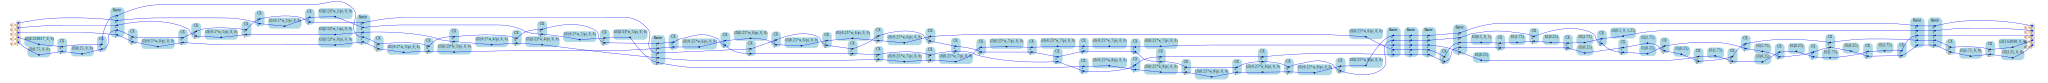

In [40]:
num_parameters = len(keys) * n_qubits
parameters = []
for i in range(num_parameters):
    parameters.append(Parameter('w_' + str(i)))
    
parameters = np.array(parameters).reshape(len(keys),n_qubits)
print('Circuit for qiskit-tket')
FC = full_circuit(parameters)

tket_back = tket_AerBackend()

FC_tket = qiskit_to_tk(FC)

tket_back.compile_circuit(FC_tket)


Graph(FC_tket).get_DAG()

In [29]:
opt = qiskit.aqua.components.optimizers.COBYLA(maxiter=100, disp=False, rhobeg=1.0, tol=1e-8)

In [30]:
weights = np.random.rand(num_parameters)
start = time.time()

Cost_hist = []
w = opt.optimize(num_vars = num_parameters , objective_function = cost_fn_qiskit_tket , gradient_function=None, 
                 variable_bounds=[(0,2*np.pi) for i in range(num_parameters)], initial_point=weights)
stop = time.time()

Cost_hist_cobyla_qiskit_tket = np.copy(Cost_hist)
Cost_hist = []

print('Total time taken : ' , stop-start)
print('Optimized Cost : ', cost_fn_qiskit_tket(w[0]))

Total time taken :  421.2102222442627
Optimized Cost :  0.000885571055326384


In [31]:
print('Optimized Parameters :  ',w[0])

Optimized Parameters :   [1.5658482  1.62601759 1.33138508 1.4407602  1.15117294 1.97389198
 1.8436109  1.94659375 0.49430837]


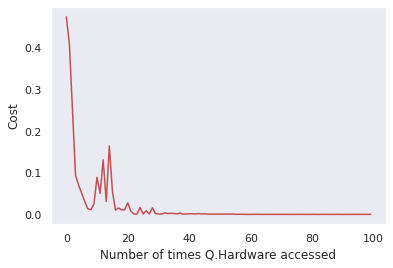

100


In [32]:
plt.plot(Cost_hist_cobyla_qiskit_tket,'r-')
plt.xlabel('Number of times Q.Hardware accessed')
plt.ylabel('Cost')
plt.grid()
plt.show()
print(len(Cost_hist_cobyla_qiskit_tket))

In [44]:
def prepare_x(weights_final):    
    
    num_parameters = len(keys) * n_qubits
    parameters = []
    for i in range(num_parameters):
        parameters.append(Parameter('w_' + str(i)))
        
    value_dict = {}
    for i in range(len(parameters)) :
        value_dict[parameters[i]] = weights[i]
    
    parameters = np.array(parameters).reshape(len(keys),n_qubits)
    
    QR = QuantumRegister(tot_qubits)
    CR = ClassicalRegister(n_qubits)
    prep_circuit = QuantumCircuit(QR,CR)
    
    prep_circuit.append(UC(),[_ for _ in range(ancilla_size)])
    prep_circuit.barrier()
    prep_circuit.append(var_circuit(parameters) , [_ for _ in range(tot_qubits)])
    
    #prep_circuit.append(UCD(),[_ for _ in range(ancilla_size)])
        
    prep_circuit = prep_circuit.bind_parameters(value_dict)
    
    prep_circuit.measure([_ for _ in range(ancilla_size,tot_qubits)],[_ for _ in range(n_qubits)])   

    prep_circuit = compiler.transpile(prep_circuit , basis_gates = ['u3','cx'],optimization_level = 3)
    
    #############################
    #############################
    # compiled buy tket and fetched back to qiskit
    
    tket_back = tket_AerBackend()
    

    prep_circuit = qiskit_to_tk(prep_circuit)
    
    tket_back.compile_circuit(prep_circuit)
    job = tket_back.get_counts(prep_circuit, n_shots)
    job = convert_format_to_qiskit(job)

    

    ##############################
    ##############################


    
    job = execute(prep_circuit , backend = Aer.get_backend('qasm_simulator') , shots = n_shots).result().get_counts()
    x = []
    for i in range(2**n_qubits):
        if convert_bin(i,n_qubits) in job.keys():
            x.append(job[convert_bin(i,n_qubits)])
        else :
            x.append(0)
    x = np.array(x)
    x = x/np.linalg.norm(x)
    print(job)
    
    return(x)

In [36]:
weights = w[0]
 ## chage this with optimised weights
X = prepare_x(weights)
print("The solution vector is : " , X)

The solution vector is :  [0.35803939 0.34084928 0.36269758 0.35199222 0.39721332 0.34458712
 0.35270648 0.31505705]


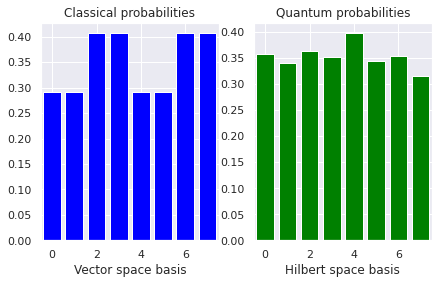

Distance between classcal value and Quantum Calculated value :  0.19408225477892563
Accuracy in percentage is  80.59177452210744 %


In [37]:
b =  [1 for _ in range(8) ]
b = b/np.linalg.norm(b)
x = np.matmul(np.linalg.inv(A),b)
c_probs = (x/np.linalg.norm(x))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), X, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

print('Distance between classcal value and Quantum Calculated value : ',np.linalg.norm(X - c_probs))
print('Accuracy in percentage is ',(1-np.linalg.norm(X - c_probs))*100 ,'%')